In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.losses import categorical_crossentropy
import pandas as pd 
from keras.regularizers import l2
from keras import models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
import numpy as np
from sklearn import linear_model

Importing the libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_set_path = "/content/drive/MyDrive/Semester 2 files/EE258/Project EE258 - Dataset/train"
test_set_path = "/content/drive/MyDrive/Semester 2 files/EE258/Project EE258 - Dataset/test"

  The train path and the test path are defined. 

In [4]:
x = plt.imread("/content/drive/MyDrive/Semester 2 files/EE258/Project EE258 - Dataset/test/happy/PrivateTest_1140198.jpg")
x.shape

(48, 48)

The drive is mounted

In [5]:
image_size = (48, 48) # (width, height)

class_map = {
    'surprise': 0,
    'fear': 1,
    'angry': 2,
    'neutral': 3,
    'sad': 4,
    'disgust': 5,
    'happy': 6
}

random_state = 40

In [6]:
!ls "/content/drive/MyDrive/Semester 2 files/EE258/Project EE258 - Dataset"

test  test_new	train  train_new


Image size, and the 7 classes of emotions are defined 

In [7]:
def create_dataset(file_path):
    df = pd.DataFrame()
    
    for cat in os.listdir(file_path):
        image_file = os.listdir(os.path.join(file_path, cat))
        label = [cat] * len(image_file)
        tmp_df = pd.DataFrame([image_file, label]).T
        tmp_df.columns = ['image_file', 'label']
        df = pd.concat([df, tmp_df])
        
    return df

def display_sample_image(img_num=10):
    plt.figure(figsize=(10,5))
    for i, v in train_df.sample(10).reset_index().iterrows():
        label = v.label
        image_file = v.image_file
        path = os.path.join(os.path.join(train_set_path, label), image_file)
        image = cv2.imread(image_file)
        plt.subplot(2,5,i+1)
        plt.grid(False)
        plt.xlabel(label)

        plt.imshow(image)

        
def preprocess_image(image):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, image_size, interpolation = cv2.INTER_AREA) # resize (48, 48)
    image = np.array(image) # convert pixel to float
    image = image.astype('float32')
    image /= 255 # normalize
    
    return image

def prepare_dataset(df, class_map):
    image_array = []
    class_name = []
    
    for i, row in df.iterrows():
        
        image_path = row.image_file
        image_class = class_map[row.label]
        
        image = cv2.imread(image_path, 0) # load image (0 = grayscale)
        image = preprocess_image(image) # preprocess (resize -> convert pixel to float -> normalize)
        
        image_array.append(image)
        class_name.append(image_class)
        
    return np.array(image_array).reshape((len(image_array), image_size[0], image_size[1], 1)), to_categorical(np.array(class_name))

Creating the dataset, displaying the sample image, prepocessing the image amd preparing the dataset funcitons are defined.

In [8]:
img_height = image_size[1]
img_width = image_size[0]
input_shape = (img_height, img_width, 1)

num_classes = len(class_map)

In [9]:
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    print(model.summary())
    
    return model



A CNN model is defined for this model. With a convolution layer of 32 and 64 feature maps, 3*3 kernel size, acrivation function RELU. Max pooling with 2*2 kernel size. And a dense layer with RELU and SOFTMAX activation functions.  

In [10]:
batch_size = 128

In [11]:
def train_model(model, train_set, val_set, optimizer, loss, metrics, epochs, batch_size, class_weight, callbacks):
    
    model.compile(optimizer=Adam(lr=1e-3, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(train_set[0], train_set[1],
                    validation_data=(val_set[0], val_set[1]), 
                    epochs=epochs,
                    batch_size=batch_size,
                    class_weight=class_weight,
                    callbacks=callbacks)
    
    return model, history

def plot_trian_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [12]:
def plot_image_and_emotion(image, label, prediction):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=False)
    
    bar_label = class_map.keys()
    
    image = np.reshape(image, (image.shape[0], image.shape[1]))
    
    axs[0].imshow(image, "gray")
    axs[0].set_title(label)
    
    axs[1].bar(bar_label, prediction)
    axs[1].grid()
    
    plt.show()

In [13]:
model_list = {
    'model_1': {
        'model': create_model,
        'trained_model': None,
        'history': None,
        'test_acc': None,
        'test_loss': None,
        'prediction': None
    },
  
}

acc_list = {
    'model_1': 0,
}

=============== CREATE DATASET ===============

train set:  (28709, 2)
test set:  (7178, 2)

=============== Prepare Dataset ===============

Train: (22967, 22967)
Validate: (5742, 5742)
Test: (7178, 7178)

=============== Train Model ===============

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
359/359 [==============================] - 69s 190ms/step - loss: 0.2744 - accuracy: 0.2905 - val_loss: 1.6723 - val_accuracy: 0.3429
Epoch 2/50
359/359 [==============================] - 68s 190ms/step - loss: 0.2390 - accuracy: 0.3991 - val_loss: 1.4901 - val_accuracy: 0.4382
Epoch 3/50
359/359 [==============================] - 68s 189ms/step - loss: 0.2147 - accuracy: 0.4678 - val_loss: 1.4412 - val_accuracy: 0.4697
Epoch 4/50
359/359 [==============================] - 68s 189ms/step - loss: 0.1999 - accuracy: 0.5041 - val_loss: 1.3700 - val_accuracy: 0.4991
Epoch 5/50
359/359 [==============================] - 68s 189ms/step - loss: 0.1893 - accuracy: 0.5325 - val_loss: 1.3037 - val_accuracy: 0.5174
Epoch 6/50
359/359 [==============================] - 68s 189ms/step - loss: 0.1799 - accuracy: 0.5545 - val_loss: 1.3021 - val_accuracy: 0.5280
Epoch 7/50
359/359 [==============================] - 68s 188ms/step - loss: 0.1723 - accuracy: 0.5793 - val_loss: 1.3085 - val_ac

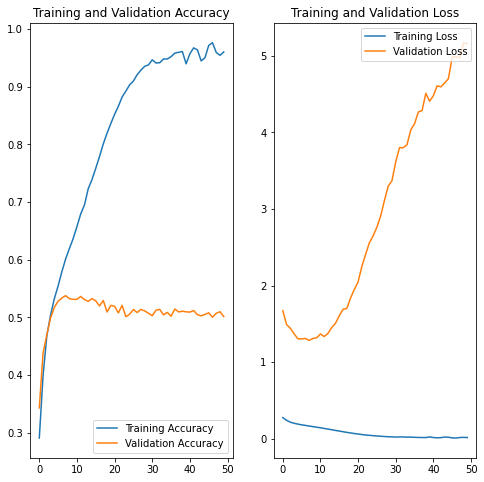

225/225 [==============================] - 6s 25ms/step - loss: 5.1094 - accuracy: 0.5089
[model_1] test accuracy:0.5089161396026611
718/718 [==============================] - 18s 26ms/step - loss: 0.1219 - accuracy: 0.9679
[model_1] train accuracy:0.9679104685783386

=============== Save Trained Model ===============



In [14]:
# 1. Create Dataset
print("=============== CREATE DATASET ===============")
print()
train_df = create_dataset(train_set_path)
train_df["image_file"] = train_df.apply(lambda x : os.path.join(os.path.join(train_set_path, x['label']), x['image_file']), axis=1)

test_df = create_dataset(test_set_path)
test_df["image_file"] = test_df.apply(lambda x : os.path.join(os.path.join(test_set_path, x['label']), x['image_file']), axis=1)

print("train set: ", train_df.shape)
print("test set: ", test_df.shape)

# display_sample_image(img_num=10)

# 2. Prepare Dataset
print()
print("=============== Prepare Dataset ===============")
print()
train_ds, val_ds = train_test_split(train_df, test_size=0.2, random_state=random_state)

X_train, y_train = prepare_dataset(train_ds, class_map)
X_val, y_val = prepare_dataset(val_ds, class_map)
X_test, y_test = prepare_dataset(test_df, class_map)

print("Train: ({}, {})".format(str(len(X_train)), str(len(y_train))))
print("Validate: ({}, {})".format(str(len(X_val)), str(len(y_val))))
print("Test: ({}, {})".format(str(len(X_test)), str(len(y_test))))

# 3. Train Model
print()
print("=============== Train Model ===============")
print()
class_weight = (train_df.label.value_counts() / train_df.shape[0])
class_weight.index = class_weight.index.map(class_map)
class_weight = class_weight.to_dict()

epochs = 50

for m in model_list:
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.1, patience=5)
    model = model_list[m]['model']
    trained_model, history = train_model(model=model(input_shape, num_classes),
                                         train_set=(X_train, y_train),
                                         val_set=(X_val, y_val),
                                         optimizer=Adam(lr=1e-3, decay=1e-6),
                                         loss=categorical_crossentropy,
                                         metrics=['accuracy'],
                                         epochs=epochs,
                                         batch_size=64,
                                         class_weight=class_weight,
                                         callbacks=None)
    
    # keep trained_model, history, prediction
    model_list[m]['trained_model'] = trained_model
    model_list[m]['history'] = history
    model_list[m]['prediction'] = trained_model.predict(X_test)
    
    # plot history
    # plot_trian_history(history, earlystop_callback.stopped_epoch + 1)
    plot_trian_history(history, epochs)
    
    # evaluate
    test_loss, test_acc = trained_model.evaluate(X_test, y_test)
    print('[{}] test accuracy:{}'.format(m, test_acc))
    # keep loss, accuracy
    model_list[m]['test_acc'] = test_acc
    model_list[m]['test_loss'] = test_loss
    acc_list[m] = test_acc
    # evaluate
    train_loss, train_acc = trained_model.evaluate(X_train, y_train)
    print('[{}] train accuracy:{}'.format(m, train_acc))
    # keep loss, accuracy
    model_list[m]['train_acc'] = train_acc
    model_list[m]['train_acc'] = train_acc
    acc_list[m] = train_acc
    
# 4. Save The Best Trained Model
print()
print("=============== Save Trained Model ===============")
print()
# serialize model to JSON
best_model = max(acc_list, key=acc_list.get)
trained_model = model_list[best_model]['trained_model']
model_json = trained_model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
trained_model.save_weights("model.h5")

In [31]:
for m in model_list:
    print("MODEL : {} - ACCURACY : {}".format(m, model_list[m]['train_acc']))
    print("MODEL : {} - ACCURACY : {}".format(m, model_list[m]['test_acc']))

MODEL : model_1 - ACCURACY : 0.9679104685783386
MODEL : model_1 - ACCURACY : 0.5089161396026611


In [33]:
sns.set(font_scale=1.5)
sns.set_style("dark")

In [34]:
def get_test_image(test_image_array, test_image_label, pred_test_labels, image_number):
    image = test_image_array[image_number]
    label = list(class_map.keys())[list(class_map.values()).index(list(test_image_label[image_number]).index(1))]
    prediction = pred_test_labels[image_number]
    
    return image, label, prediction

In [35]:
pred_test_labels = model_list[best_model]['prediction']
test_df.reset_index().sample(10)

index                                         image_file     label
6219    274  /content/drive/MyDrive/Semester 2 files/EE258/...   neutral
5499    623  /content/drive/MyDrive/Semester 2 files/EE258/...     angry
3901    799  /content/drive/MyDrive/Semester 2 files/EE258/...     happy
892      61  /content/drive/MyDrive/Semester 2 files/EE258/...       sad
2547    469  /content/drive/MyDrive/Semester 2 files/EE258/...      fear
1728    897  /content/drive/MyDrive/Semester 2 files/EE258/...       sad
398     398  /content/drive/MyDrive/Semester 2 files/EE258/...  surprise
2361    283  /content/drive/MyDrive/Semester 2 files/EE258/...      fear
1679    848  /content/drive/MyDrive/Semester 2 files/EE258/...       sad
3652    550  /content/drive/MyDrive/Semester 2 files/EE258/...     happy

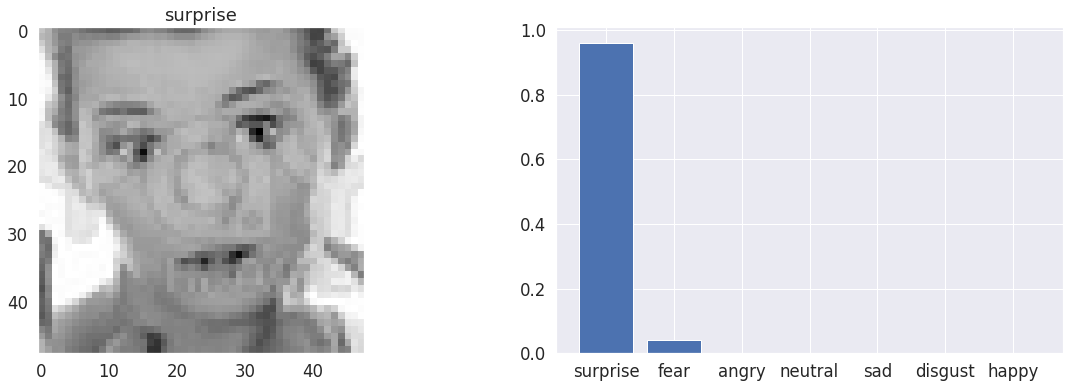

In [36]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=25)
plot_image_and_emotion(image, label, prediction)

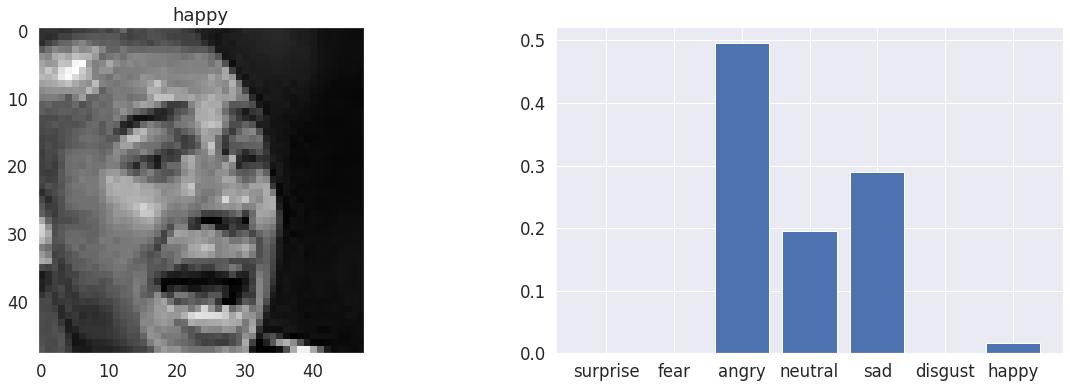

In [37]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=4444)
plot_image_and_emotion(image, label, prediction)

In [38]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=77)
plot_image_and_emotion(image, label, prediction)

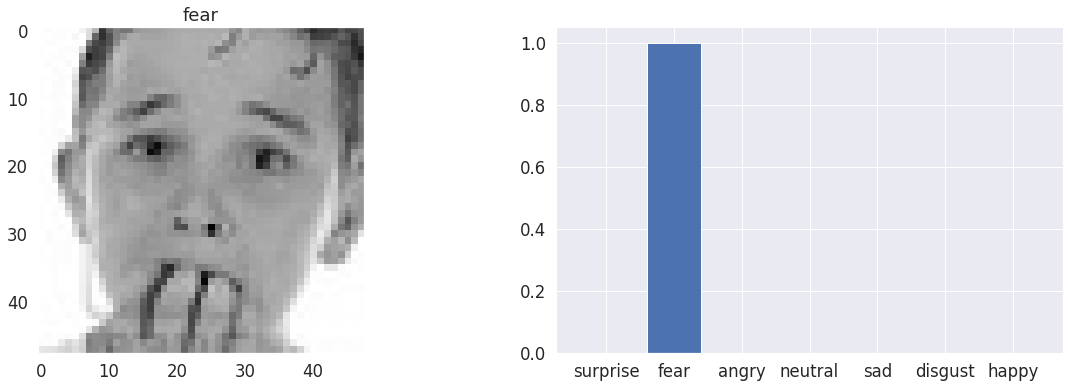

In [39]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=2478)
plot_image_and_emotion(image, label, prediction)

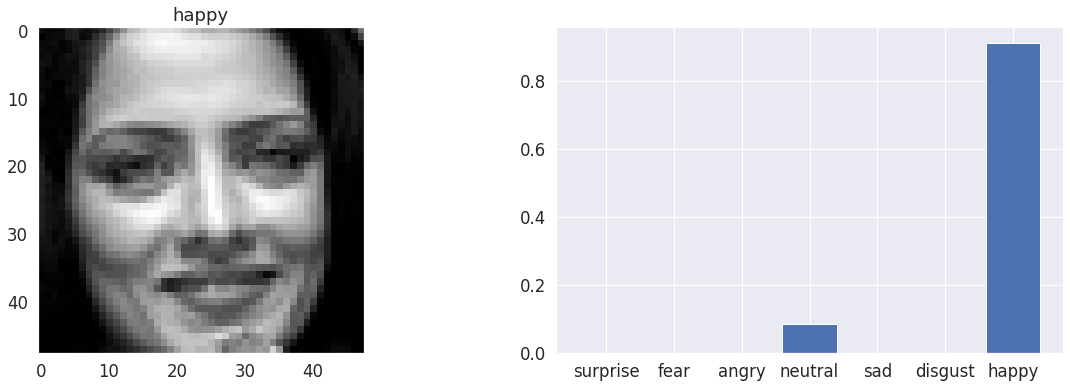

In [40]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=3469)
plot_image_and_emotion(image, label, prediction)

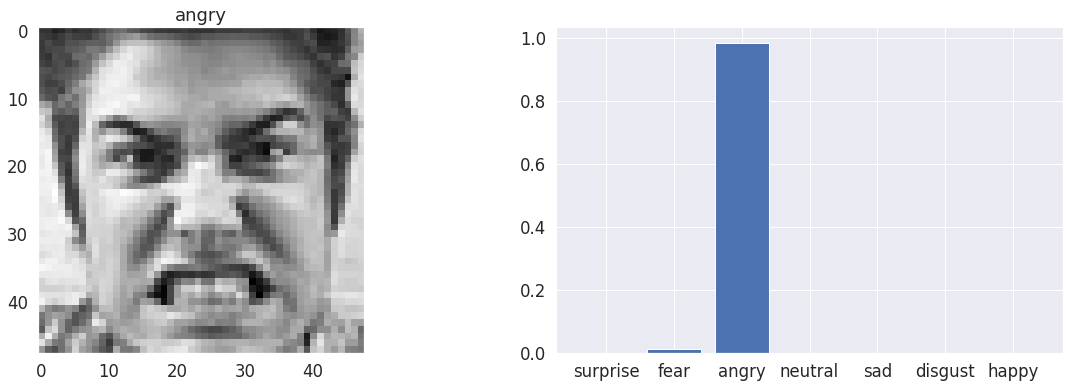

In [41]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=5678)
plot_image_and_emotion(image, label, prediction)

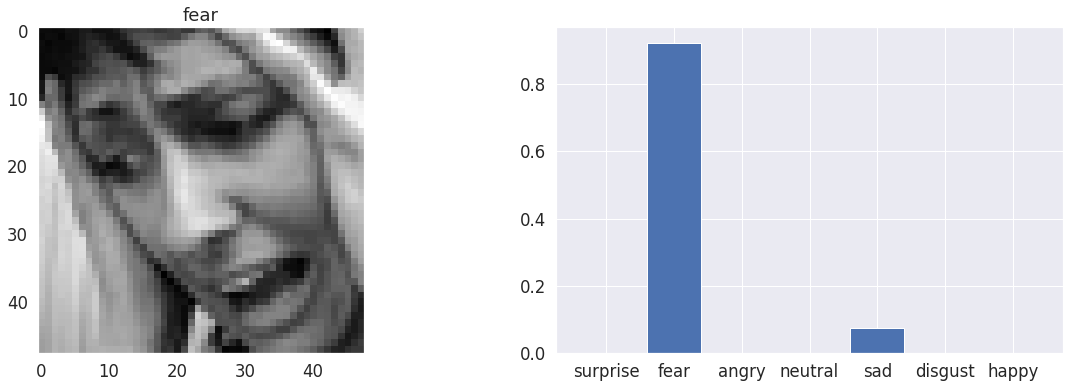

In [42]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=2345)
plot_image_and_emotion(image, label, prediction)

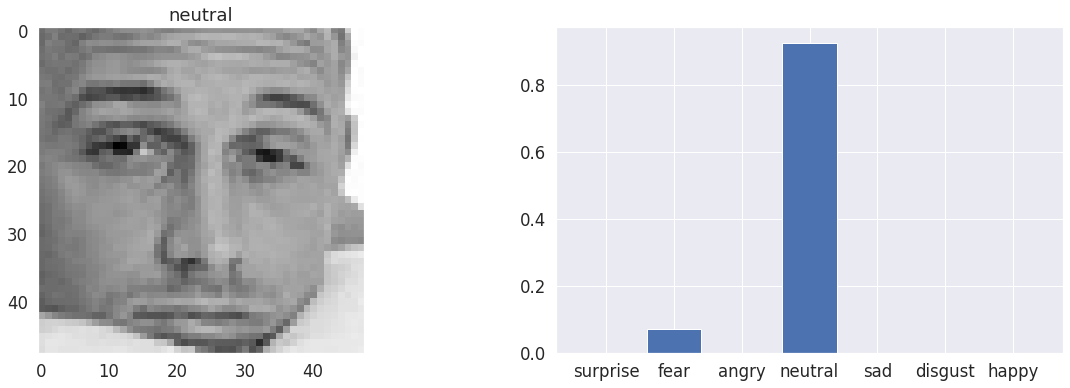

In [43]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=6756)
plot_image_and_emotion(image, label, prediction)

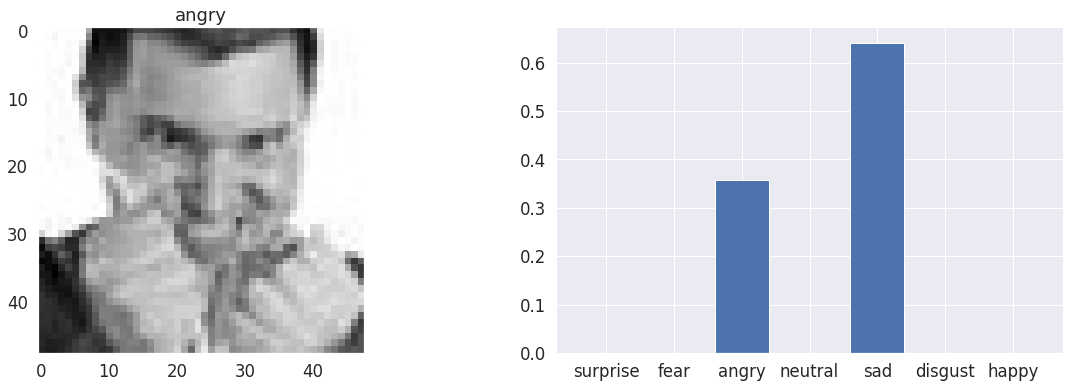

In [44]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=5656)
plot_image_and_emotion(image, label, prediction)

In [45]:
image, label, prediction =  get_test_image(X_test, y_test, pred_test_labels, image_number=6900)
plot_image_and_emotion(image, label, prediction)

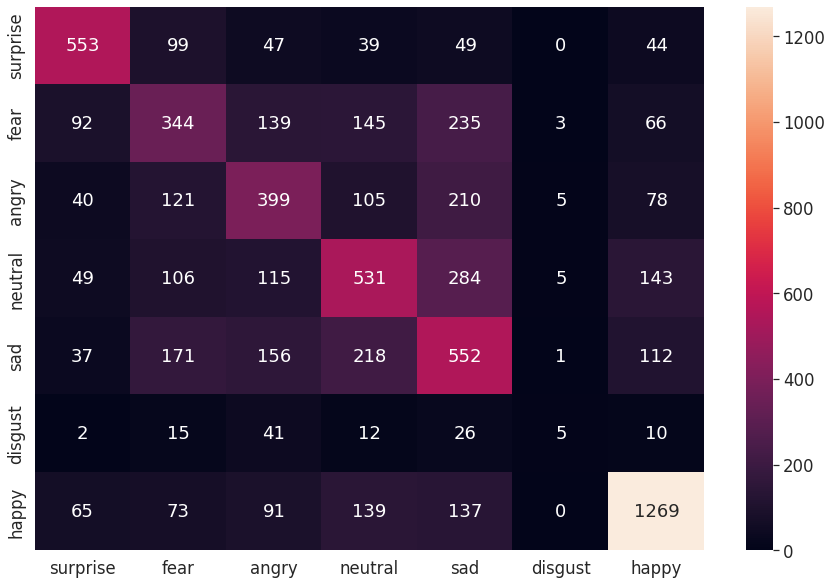

In [46]:
key_list = list(class_map.keys())
val_list = list(class_map.values())
c_matrix = confusion_matrix(y_true=np.argmax(y_test, axis=1).tolist(), 
                            y_pred=np.argmax(pred_test_labels, axis=1).tolist())

plt.subplots(figsize=(15, 10))
sns.heatmap(c_matrix, annot=True,  fmt='d', xticklabels=key_list, yticklabels=key_list)

In [47]:
print(classification_report(y_true=np.argmax(y_test, axis=1).tolist(), 
                            y_pred=np.argmax(pred_test_labels, axis=1).tolist(),
                            target_names=list(class_map.keys())))

              precision    recall  f1-score   support

    surprise       0.66      0.67      0.66       831
        fear       0.37      0.34      0.35      1024
       angry       0.40      0.42      0.41       958
     neutral       0.45      0.43      0.44      1233
         sad       0.37      0.44      0.40      1247
     disgust       0.26      0.05      0.08       111
       happy       0.74      0.72      0.73      1774

    accuracy                           0.51      7178
   macro avg       0.46      0.44      0.44      7178
weighted avg       0.51      0.51      0.51      7178

